In [1]:
import tensorflow as tf
import numpy as np

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 创建一个计算图并在会话中执行

In [2]:
x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')
f = x * x * y + 2

sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

38


In [3]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
    print(result)

38


In [4]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    result = f.eval()
    print(result)

38


In [5]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

38


# 管理图

In [6]:
x1 = tf.Variable(1)
x.graph is tf.get_default_graph()

True

In [7]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)
    print(x2.graph is graph)
    print(x2.graph is tf.get_default_graph())
    
print(x2.graph is graph)
print(x2.graph is tf.get_default_graph())

True
True
True
False


# 重置默认图

In [8]:
tf.reset_default_graph()

# 节点的生命周期

In [9]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())

10
15


In [10]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)
    print(z_val)

10
15


# TensorFlow中的线性回归 （Normal Equation）

In [11]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
print(housing.data.shape)

(20640, 8)


In [12]:
#np.c_是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等，类似于pandas中的merge()
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]
print(housing_data_plus_bias.shape)

(20640, 9)


In [13]:
print(housing.target.shape)
print(housing.target.reshape(-1, 1).shape)

(20640,)
(20640, 1)


In [14]:
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()
    print(theta_value)
    print(theta_value.shape)

[[-3.7465141e+01]
 [ 4.3573415e-01]
 [ 9.3382923e-03]
 [-1.0662201e-01]
 [ 6.4410698e-01]
 [-4.2513184e-06]
 [-3.7732250e-03]
 [-4.2664889e-01]
 [-4.4051403e-01]]
(9, 1)


# 梯度下降

### 归一化

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]
print(scaled_housing_data_plus_bias.shape)

(20640, 9)


### 手工计算梯度

In [16]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01
"""
tf.random_uniform(
    shape,
    minval=0,
    maxval=None,
    dtype=tf.float32,
    seed=None,
    name=None
)
"""
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="Y")
theta = tf.Variable(tf.random_uniform((n + 1, 1), -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2 / m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(theta.eval())
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE = ", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print(best_theta)

[[-0.94757867]
 [-0.1310606 ]
 [-0.46626925]
 [ 0.42084408]
 [ 0.7682936 ]
 [-0.6444173 ]
 [ 0.09057188]
 [-0.39489198]
 [-0.6565814 ]]
Epoch 0 MSE =  12.408029
Epoch 100 MSE =  0.7551968
Epoch 200 MSE =  0.5420869
Epoch 300 MSE =  0.53316975
Epoch 400 MSE =  0.53053766
Epoch 500 MSE =  0.52879685
Epoch 600 MSE =  0.52754843
Epoch 700 MSE =  0.52664953
Epoch 800 MSE =  0.52600086
Epoch 900 MSE =  0.5255332
[[ 2.0685525e+00]
 [ 8.1063598e-01]
 [ 1.2685774e-01]
 [-2.0784086e-01]
 [ 2.4839851e-01]
 [-1.3083934e-03]
 [-3.9607052e-02]
 [-8.5861278e-01]
 [-8.2600284e-01]]


### 使用自动微分 tf.gradients()

In [17]:
reset_graph()

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="Y")
theta = tf.Variable(tf.random_uniform((n + 1, 1), -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = tf.gradients(mse, [theta])[0]
# gradients = 2 / m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(theta.eval())
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE = ", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print(best_theta)

[[-0.94757867]
 [-0.1310606 ]
 [-0.46626925]
 [ 0.42084408]
 [ 0.7682936 ]
 [-0.6444173 ]
 [ 0.09057188]
 [-0.39489198]
 [-0.6565814 ]]
Epoch 0 MSE =  12.408029
Epoch 100 MSE =  0.7551966
Epoch 200 MSE =  0.5420869
Epoch 300 MSE =  0.53316975
Epoch 400 MSE =  0.53053766
Epoch 500 MSE =  0.52879685
Epoch 600 MSE =  0.52754843
Epoch 700 MSE =  0.52664953
Epoch 800 MSE =  0.52600086
Epoch 900 MSE =  0.5255332
[[ 2.0685525e+00]
 [ 8.1063598e-01]
 [ 1.2685777e-01]
 [-2.0784083e-01]
 [ 2.4839847e-01]
 [-1.3083883e-03]
 [-3.9607048e-02]
 [-8.5861266e-01]
 [-8.2600272e-01]]


### 使用优化器

In [18]:
reset_graph()

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="Y")
theta = tf.Variable(tf.random_uniform((n + 1, 1), -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
# gradients = 2 / m * tf.matmul(tf.transpose(X), error)
# training_op = tf.assign(theta, theta - learning_rate * gradients)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(theta.eval())
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE = ", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print(best_theta)

[[-0.94757867]
 [-0.1310606 ]
 [-0.46626925]
 [ 0.42084408]
 [ 0.7682936 ]
 [-0.6444173 ]
 [ 0.09057188]
 [-0.39489198]
 [-0.6565814 ]]
Epoch 0 MSE =  12.408029
Epoch 100 MSE =  0.7551966
Epoch 200 MSE =  0.5420869
Epoch 300 MSE =  0.53316975
Epoch 400 MSE =  0.53053766
Epoch 500 MSE =  0.52879685
Epoch 600 MSE =  0.52754843
Epoch 700 MSE =  0.52664953
Epoch 800 MSE =  0.52600086
Epoch 900 MSE =  0.5255332
[[ 2.0685525e+00]
 [ 8.1063598e-01]
 [ 1.2685777e-01]
 [-2.0784083e-01]
 [ 2.4839847e-01]
 [-1.3083883e-03]
 [-3.9607048e-02]
 [-8.5861266e-01]
 [-8.2600272e-01]]


In [19]:
reset_graph()

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="Y")
theta = tf.Variable(tf.random_uniform((n + 1, 1), -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
# gradients = 2 / m * tf.matmul(tf.transpose(X), error)
# training_op = tf.assign(theta, theta - learning_rate * gradients)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print(theta.eval())
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE = ", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print(best_theta)

[[-0.94757867]
 [-0.1310606 ]
 [-0.46626925]
 [ 0.42084408]
 [ 0.7682936 ]
 [-0.6444173 ]
 [ 0.09057188]
 [-0.39489198]
 [-0.6565814 ]]
Epoch 0 MSE =  12.408029
Epoch 100 MSE =  0.52520055
Epoch 200 MSE =  0.52433306
Epoch 300 MSE =  0.524321
Epoch 400 MSE =  0.52432114
Epoch 500 MSE =  0.5243208
Epoch 600 MSE =  0.52432054
Epoch 700 MSE =  0.52432054
Epoch 800 MSE =  0.5243205
Epoch 900 MSE =  0.5243205
[[ 2.068558  ]
 [ 0.8296182 ]
 [ 0.11875144]
 [-0.26552498]
 [ 0.3056947 ]
 [-0.00450307]
 [-0.03932622]
 [-0.89988816]
 [-0.8705434 ]]


### 占位符

In [20]:
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})
print(B_val_1)
print(B_val_2)

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


### mini-batch

In [21]:
reset_graph()

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform((n + 1, 1), -1.0, 1.0, seed=42), 
                    name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)
    #print(theta.eval())
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    
    best_theta = theta.eval()
print(best_theta)

[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


### 保存和恢复模型

In [22]:
reset_graph()

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="Y")
theta = tf.Variable(tf.random_uniform((n + 1, 1), -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
"""
"""
saver = tf.train.Saver()
n_epochs = 1000

with tf.Session() as sess:
    sess.run(init)
    print(theta.eval())
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE = ", mse.eval())
            save_path = saver.save(sess, "tmp/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "tmp/my_model_final.ckpt")
print(best_theta)

[[-0.94757867]
 [-0.1310606 ]
 [-0.46626925]
 [ 0.42084408]
 [ 0.7682936 ]
 [-0.6444173 ]
 [ 0.09057188]
 [-0.39489198]
 [-0.6565814 ]]
Epoch 0 MSE =  12.408029
Epoch 100 MSE =  0.52520055
Epoch 200 MSE =  0.52433306
Epoch 300 MSE =  0.524321
Epoch 400 MSE =  0.52432114
Epoch 500 MSE =  0.5243208
Epoch 600 MSE =  0.52432054
Epoch 700 MSE =  0.52432054
Epoch 800 MSE =  0.5243205
Epoch 900 MSE =  0.5243205
[[ 2.068558  ]
 [ 0.8296182 ]
 [ 0.11875144]
 [-0.26552498]
 [ 0.3056947 ]
 [-0.00450307]
 [-0.03932622]
 [-0.89988816]
 [-0.8705434 ]]


In [23]:
with tf.Session() as sess:
    saver.restore(sess, "tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval()
    print(best_theta_restored)

INFO:tensorflow:Restoring parameters from tmp/my_model_final.ckpt
[[ 2.068558  ]
 [ 0.8296182 ]
 [ 0.11875144]
 [-0.26552498]
 [ 0.3056947 ]
 [-0.00450307]
 [-0.03932622]
 [-0.89988816]
 [-0.8705434 ]]


# TensorBoard

In [40]:
reset_graph()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}".format(root_logdir, now)

In [41]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform((n + 1, 1), -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [42]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [43]:
with tf.Session() as sess:
    sess.run(init)
    print(theta.eval())
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})  
    best_theta = theta.eval()

[[-0.1673944 ]
 [-0.46283674]
 [-0.04063368]
 [-0.27085733]
 [ 0.9094229 ]
 [ 0.8837292 ]
 [ 0.2296679 ]
 [-0.2831571 ]
 [ 0.18720484]]


In [44]:
file_writer.close()

In [45]:
print(best_theta)

[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


# 命名作用域

In [46]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}".format(root_logdir, now)

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform((n + 1, 1), -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
# error = y_pred - y
# mse = tf.reduce_mean(tf.square(error), name="mse")
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})  
    best_theta = theta.eval()

In [47]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

In [48]:
print(error.op.name)

loss/sub


In [49]:
print(mse.op.name)

loss/mse


# 模块化

In [55]:
def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

In [56]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("tf_logs/relu1", tf.get_default_graph())

In [57]:
def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, 0., name="relu")
    
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("tf_logs/relu2", tf.get_default_graph())

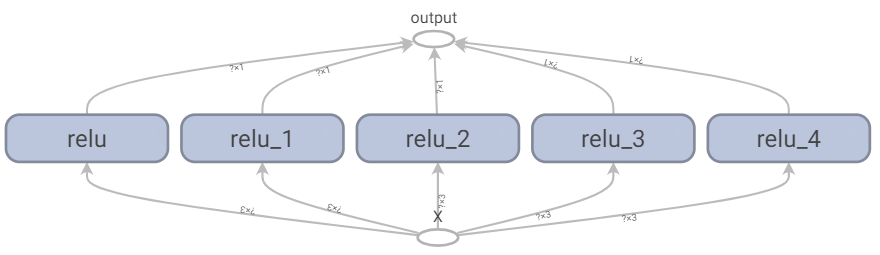

# 共享变量

In [53]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")

threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")

In [58]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"): #hasattr() 函数用于判断对象是否包含对应的属性
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, relu.threshold, name="max")

In [59]:
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))